In [1]:
%%capture
!pip install -U scikit-learn pandas
!pip install numpy
!pip install seaborn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix

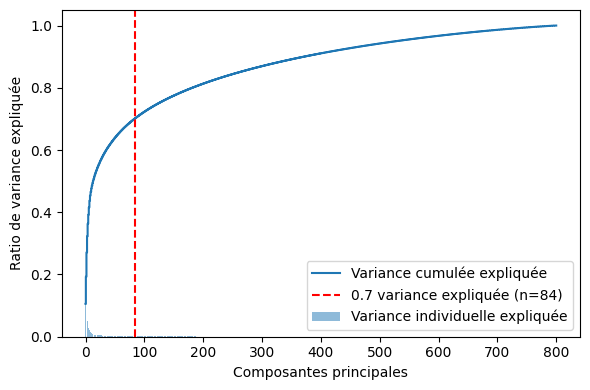

In [2]:
# Lire le fichier CSV
df = pd.read_csv('data.csv')

# Prétraitement des données
# Nommer la première colonne 'patient' dans le DataFrames
df.columns.values[0] = 'patient'

# Séparation du reste des données
y = df.iloc[:, 0].values
X = df.iloc[:, 1:].values

# Normaliser les caractéristiques
X = StandardScaler().fit_transform(X)

# Appliquer la PCA au maximum de composante
pca = PCA(n_components=801) # Vous pouvez changer le nombre de composantes
X_pca = pca.fit_transform(X)

# Calculer la variance expliquée par chaque composante principale
explained_variance = pca.explained_variance_ratio_

# Générer les noms de colonnes pour toutes les composantes principales
column_names = [f'Composante principale {i+1}' for i in range(pca.n_components_)]

# Convertir X_pca en DataFrame avec les noms de colonnes appropriés
df_pca = pd.DataFrame(data = X_pca, columns = column_names)

# Si vous voulez ajouter les résultats à votre DataFrame original
df_final = pd.concat([df_pca, df[['patient']]], axis = 1)

# Définir l'ordre des colonnes
cols = ['patient']  + [col for col in df_final if col != 'patient']

# Réorganiser les colonnes
df_final = df_final[cols]

# Afficher les 10 premières lignes
###print(df_final.head(10))

# Calculer la variance cumulée
cumulative_variance = np.cumsum(explained_variance)

# Trouver le nombre de composantes principales nécessaires pour atteindre un ratio de variance expliqué de 0.7
num_components = np.where(cumulative_variance >= 0.7)[0][0]

# Créer un éboulis des valeurs propres
plt.figure(figsize=(6, 4))
plt.bar(range(len(explained_variance)), explained_variance, alpha=0.5, align='center', label='Variance individuelle expliquée')
plt.step(range(len(explained_variance)), cumulative_variance, where='mid', label='Variance cumulée expliquée')

# Ajouter une ligne verticale rouge au point où le ratio de variance expliquée atteint 0.7
plt.axvline(x=num_components, color='r', linestyle='--', label=f'0.7 variance expliquée (n={num_components})')

plt.ylabel('Ratio de variance expliquée')
plt.xlabel('Composantes principales')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [3]:
# Appliquer la PCA au avec un nombre de composante = 0.7 du ratio de variance
pca = PCA(n_components=84) # Vous pouvez changer le nombre de composantes
X_pca = pca.fit_transform(X)

# Générer les noms de colonnes pour toutes les composantes principales
column_names = [f'Composante principale {i+1}' for i in range(pca.n_components_)]

# Convertir X_pca en DataFrame avec les noms de colonnes appropriés
df_pca = pd.DataFrame(data = X_pca, columns = column_names)

# Si vous voulez ajouter les résultats à votre DataFrame original
df_final = pd.concat([df_pca, df[['patient']]], axis = 1)

# Définir l'ordre des colonnes
cols = ['patient']  + [col for col in df_final if col != 'patient']

# Réorganiser les colonnes
df_final = df_final[cols]

# Afficher les 10 premières lignes
###print(df_final.head(10))

In [4]:
# Lire les deux fichiers CSV
df_genes = df_final
df_cancers = pd.read_csv('labels.csv')

# Nommer la première colonne 'patient' dans les deux DataFrames
df_cancers.columns.values[0] = 'patient'

# Fusionner les deux DataFrames sur la colonne 'patient'
df_merged = pd.merge(df_genes, df_cancers, on='patient')

# Obtenir le nom de la dernière colonne
last_col_name = df_merged.columns[-1]

# Créer une nouvelle liste d'ordre de colonnes
new_order = [df_merged.columns[0], last_col_name] + list(df_merged.columns[1:-1])

# Réorganiser les colonnes
df_reordered = df_merged.reindex(columns=new_order)

# Créer un objet LabelEncoder
le = LabelEncoder()

# Utiliser LabelEncoder pour transformer les classes de cancer en nombres entiers
df_reordered['Class'] = le.fit_transform(df_reordered['Class'])

# Enregistrer le DataFrame réorganisé dans un nouveau fichier CSV
df_reordered.to_csv('reordered.csv', index=False)


In [5]:
# Charger les données
data = pd.read_csv('reordered.csv')

# Séparer les caractéristiques et la cible
X = data.drop(['Class','patient'], axis=1)
y = data['Class']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scores de cross-validation : [0.9382716 0.95      0.9625    0.9       0.9125    0.9125    0.8625
 0.9375    0.9625    0.925    ]
Précision de l'arbre de décision : 0.9440993788819876


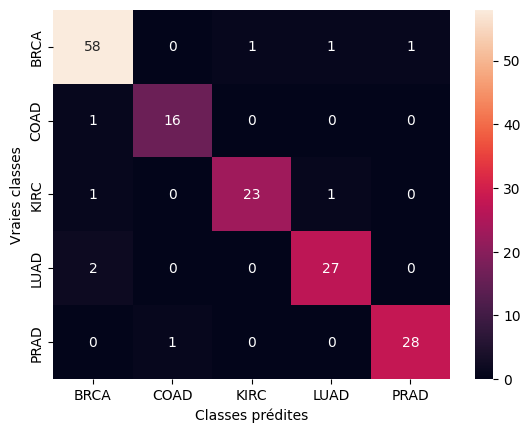

In [6]:
# Créer et entraîner un modèle d'arbre de décision
tree = DecisionTreeClassifier()

# Cross-validation
scores_t = cross_val_score(tree, X, y, cv=10)
print("Scores de cross-validation :", scores_t)

# Entrainement final tree
tree.fit(X_train, y_train)

# Prédire les classes pour l'ensemble de test
y_pred_tree = tree.predict(X_test)

# Calculer la précision de l'arbre de décision
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print(f'Précision de l\'arbre de décision : {accuracy_tree}')

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred_tree)

# Définir les labels des classes
classes = ["BRCA", "COAD", "KIRC", "LUAD", "PRAD"]

# Afficher la matrice de confusion
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.ylabel('Vraies classes')
plt.xlabel('Classes prédites')
plt.show()

Scores de cross-validation : [0.96296296 0.975      1.         0.9875     0.9625     0.975
 1.         0.975      0.9875     0.9625    ]
Précision de la forêt aléatoire : 0.9875776397515528


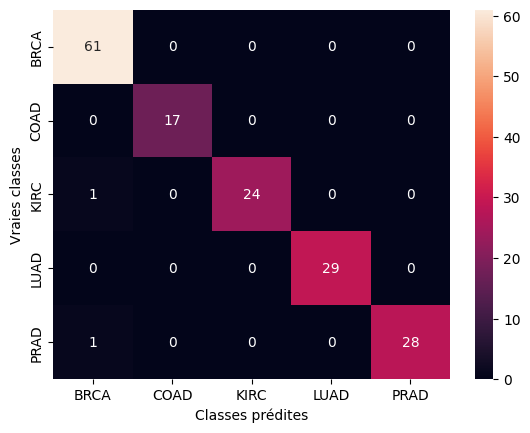

In [7]:
# Créer un modèle de forêt aléatoire
forest = RandomForestClassifier()

# Cross-validation
scores_f = cross_val_score(forest, X, y, cv=10)
print("Scores de cross-validation :", scores_f)

# Entrainement finale forest
forest.fit(X_train, y_train)

# Prédire les classes pour l'ensemble de test
y_pred_forest = forest.predict(X_test)

# Calculer la précision de la forêt aléatoire
accuracy_forest = accuracy_score(y_test, y_pred_forest)
print(f'Précision de la forêt aléatoire : {accuracy_forest}')

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred_forest)

# Définir les labels des classes
classes = ["BRCA", "COAD", "KIRC", "LUAD", "PRAD"]

# Afficher la matrice de confusion
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.ylabel('Vraies classes')
plt.xlabel('Classes prédites')
plt.show()

In [8]:
## Vérification manuel de la prédiction des modèles
#choisir la ligne du patient dont on verifiera la class manuellement
patient_id = 8
patient_data = X.loc[patient_id]

# Vérifier la dimension de patient_data
if len(patient_data.shape) == 1:
    # Si patient_data est une série, la convertir en un dataframe d'une ligne
    patient_data = patient_data.to_frame().T

# Utiliser le modèle pour prédire la classe de cancer
patient_pred_tree = tree.predict(patient_data)
patient_pred_forest = forest.predict(patient_data)

print(f'Prédiction de l\'arbre de décision pour le patient {patient_id} : {patient_pred_tree[0]}')
print(f'Prédiction de la forêt aléatoire pour le patient {patient_id} : {patient_pred_forest[0]}')


Prédiction de l'arbre de décision pour le patient 8 : 0
Prédiction de la forêt aléatoire pour le patient 8 : 0


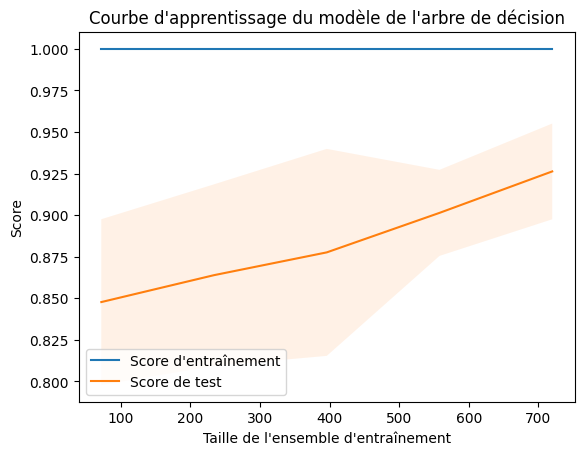

In [9]:
# Générer la courbe d'apprentissage pour le model tree
train_sizes, train_scores, test_scores = learning_curve(tree, X, y, cv=10)

# Calculer la moyenne et l'écart-type des scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Tracer la courbe d'apprentissage
plt.plot(train_sizes, train_mean, label="Score d'entraînement")
plt.plot(train_sizes, test_mean, label="Score de test")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title("Courbe d'apprentissage du modèle de l'arbre de décision")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Score")
plt.legend()
plt.show()

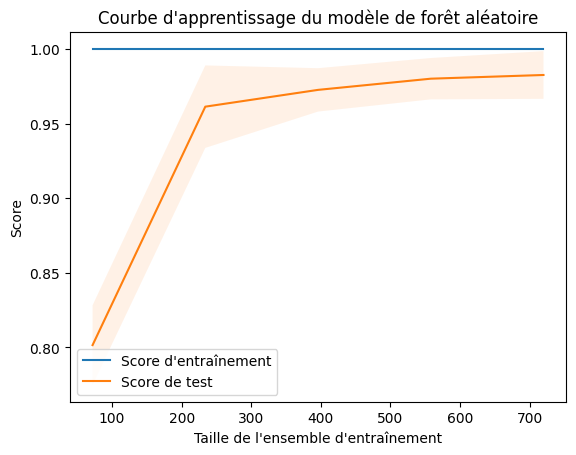

In [10]:
# Générer la courbe d'apprentissage pour le model forest
train_sizes, train_scores, test_scores = learning_curve(forest, X, y, cv=10)

# Calculer la moyenne et l'écart-type des scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Tracer la courbe d'apprentissage
plt.plot(train_sizes, train_mean, label="Score d'entraînement")
plt.plot(train_sizes, test_mean, label="Score de test")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title("Courbe d'apprentissage du modèle de forêt aléatoire")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Score")
plt.legend()
plt.show()